# Intel Image Classification in Jupyter Notebook

## 1. Setup & Install Required Libraries

    Run this in the first cell to install necessary libraries:

In [3]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## 2. Import Required Libraries
    
    Create a new cell to import the libraries:

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## 3. Dataset Loading and Preprocessing:

    load and preprocess the dataset:

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load datasets
train_dataset = datasets.ImageFolder('Data/seg_train/seg_train', transform=transform)
test_dataset = datasets.ImageFolder('Data/seg_test/seg_test', transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Display class labels
train_dataset.classes


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

## 4. Build the CNN Model

    In the next cell, define a simple CNN architecture:

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 6)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## 5. Train the Model

    Now, train your model with the following code:

In [7]:
torch.cuda.is_available()

True

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


cuda
Epoch 1/20, Loss: 0.9602
Epoch 2/20, Loss: 0.7127
Epoch 3/20, Loss: 0.6213
Epoch 4/20, Loss: 0.5639
Epoch 5/20, Loss: 0.5464
Epoch 6/20, Loss: 0.5045
Epoch 7/20, Loss: 0.4933
Epoch 8/20, Loss: 0.4639
Epoch 9/20, Loss: 0.4512
Epoch 10/20, Loss: 0.4393
Epoch 11/20, Loss: 0.4192
Epoch 12/20, Loss: 0.4139
Epoch 13/20, Loss: 0.4070
Epoch 14/20, Loss: 0.3981
Epoch 15/20, Loss: 0.3877
Epoch 16/20, Loss: 0.3806
Epoch 17/20, Loss: 0.3764
Epoch 18/20, Loss: 0.3587
Epoch 19/20, Loss: 0.3513
Epoch 20/20, Loss: 0.3411


## 6. Evaluate the Model:

    After training, evaluate the model’s performance:

Test Accuracy: 0.8730
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       437
           1       0.95      0.99      0.97       474
           2       0.82      0.87      0.84       553
           3       0.89      0.77      0.83       525
           4       0.88      0.91      0.89       510
           5       0.80      0.95      0.87       501

    accuracy                           0.87      3000
   macro avg       0.88      0.87      0.87      3000
weighted avg       0.88      0.87      0.87      3000



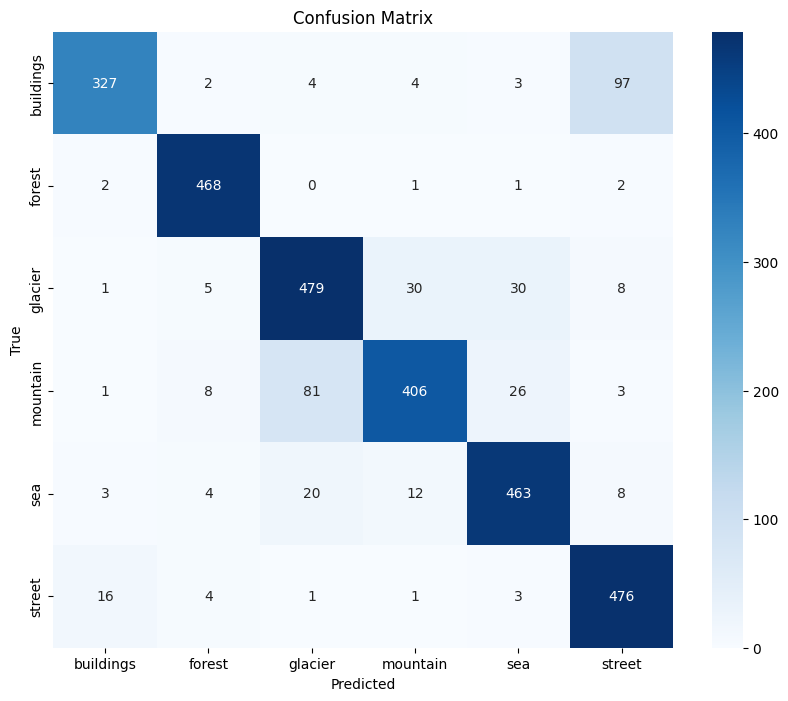

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds)
print(f'Test Accuracy: {acc:.4f}')
print(report)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## 7. Visualize Results:
    Visualize the images and predictions:

Class distribution in selected images:


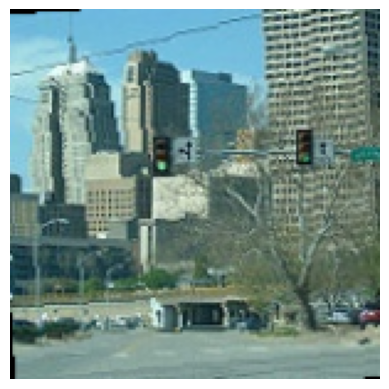

Predicted: buildings | True: buildings


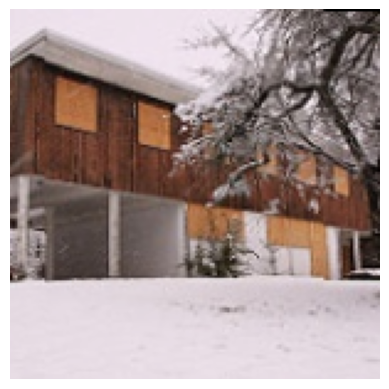

Predicted: buildings | True: buildings


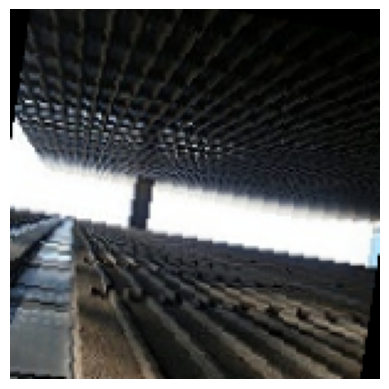

Predicted: street | True: buildings


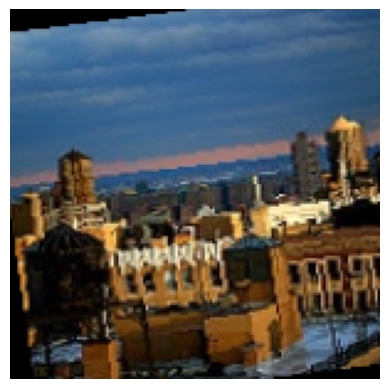

Predicted: buildings | True: buildings


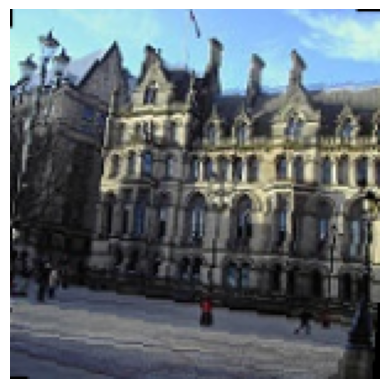

Predicted: street | True: buildings

Class distribution summary:
buildings: 5 images


In [16]:
# Define helper function to display images
import numpy as np
def imshow(img):
    img = img.permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Test one batch
images, labels = next(iter(test_loader))
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

# Set a random seed based on current time to ensure different selections each time
import time
torch.manual_seed(int(time.time()))

# Generate 5 random indices
random_indices = torch.randperm(len(images))[:5]

# Visualize 5 random images with class distribution
print("Class distribution in selected images:")
class_counts = {}
for i in random_indices:
    class_name = train_dataset.classes[labels[i]]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1
    imshow(images[i])
    print(f'Predicted: {train_dataset.classes[preds[i]]} | True: {class_name}')

print("\nClass distribution summary:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")